Dataset: dataset: https://finance.yahoo.com/quote/GE/history/

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [50]:
#Read the csv file
df = pd.read_csv('GE.csv')
print(df.head()) #7 columns, including the Date.

         Date       Open       High        Low      Close  Adj Close    Volume
0  2022-10-07  51.217800  51.350506  50.039032  50.398125  50.229530   5471920
1  2022-10-10  50.780640  51.225605  50.007805  50.725994  50.556301   4600327
2  2022-10-11  50.343483  50.944576  49.242779  49.960968  49.793835   6784048
3  2022-10-12  49.718971  51.069477  49.227165  50.538643  50.369583   6862189
4  2022-10-13  49.718971  53.364559  49.328648  53.036690  52.859272  10230578


In [51]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.


236   2023-09-18
237   2023-09-19
238   2023-09-20
239   2023-09-21
240   2023-09-22
241   2023-09-25
242   2023-09-26
243   2023-09-27
244   2023-09-28
245   2023-09-29
246   2023-10-02
247   2023-10-03
248   2023-10-04
249   2023-10-05
250   2023-10-06
Name: Date, dtype: datetime64[ns]


In [52]:

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training.
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [53]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [54]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [55]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [56]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [57]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

In [58]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [59]:

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 5s 72ms/step - loss: 0.4639 - val_loss: 0.5134
Epoch 2/5
14/14 [==============================] - 0s 29ms/step - loss: 0.1172 - val_loss: 0.3192
Epoch 3/5
14/14 [==============================] - 0s 27ms/step - loss: 0.0743 - val_loss: 0.0127
Epoch 4/5
14/14 [==============================] - 0s 26ms/step - loss: 0.0536 - val_loss: 0.0733
Epoch 5/5
14/14 [==============================] - 0s 27ms/step - loss: 0.0432 - val_loss: 0.0119


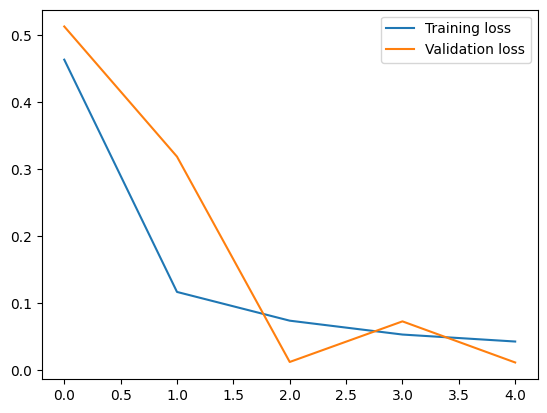

In [61]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [62]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

In [63]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2023-09-15 00:00:00', freq='C'), Timestamp('2023-09-18 00:00:00', freq='C'), Timestamp('2023-09-19 00:00:00', freq='C'), Timestamp('2023-09-20 00:00:00', freq='C'), Timestamp('2023-09-21 00:00:00', freq='C'), Timestamp('2023-09-22 00:00:00', freq='C'), Timestamp('2023-09-25 00:00:00', freq='C'), Timestamp('2023-09-26 00:00:00', freq='C'), Timestamp('2023-09-27 00:00:00', freq='C'), Timestamp('2023-09-28 00:00:00', freq='C'), Timestamp('2023-09-29 00:00:00', freq='C'), Timestamp('2023-10-02 00:00:00', freq='C'), Timestamp('2023-10-03 00:00:00', freq='C'), Timestamp('2023-10-04 00:00:00', freq='C'), Timestamp('2023-10-05 00:00:00', freq='C')]


In [64]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 305ms/step


In [65]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [66]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [71]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

<ipython-input-71-023fd395994a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [72]:
original['Date']

0     2022-10-07
1     2022-10-10
2     2022-10-11
3     2022-10-12
4     2022-10-13
         ...    
246   2023-10-02
247   2023-10-03
248   2023-10-04
249   2023-10-05
250   2023-10-06
Name: Date, Length: 251, dtype: datetime64[ns]

In [70]:
# # Assuming you have a DataFrame named 'df'

# original = df[['Date', 'Open']]
# original['Date'] = pd.to_datetime(original['Date'])
# original1 = original.loc[original['Date'] >= '2020-05-01']

# # Now, if you want to assign a value to the 'Date' column, use .loc like this:
# original1.loc[original['Date'] >= '2020-05-01', 'Date'] = '2023-10-07'

<ipython-input-70-afa274871359>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

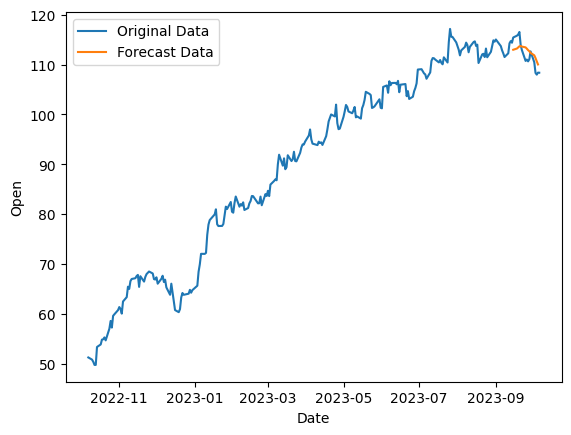

In [73]:
sns.lineplot(data=original, x='Date', y='Open', label='Original Data')

# Create line plots for 'df_forecast' DataFrame
sns.lineplot(data=df_forecast, x='Date', y='Open', label='Forecast Data')